# Plot Summary ROH for Ancients, & HO
Important: Has Function to save the Summary .csv that is also needed in Violin Plot!

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp
from scipy import stats

socket_name = socket.gethostname()
print(socket_name)

if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine

elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster

else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./PackagesSupport/")  # Since now we are in the Root Directory
from pp_individual_roh_csvs import post_process_roh_df, merge_called_blocks, individual_roh_statistic  # Import PP Functions
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

########## Some key Parameters
meta_path = "./Data/Marcus2019_1240k/meta_rev_final.csv"
#meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"  ### Important: Meta with unique IDs!
meta_df = pd.read_csv(meta_path)  # Load the Meta File

anc_sardind= 85
anc_ind =  1087

midway2-0403.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Functions for loading the ROH Data

In [32]:
def get_ancient_sardinians(meta_path, min_cov=0.5, min_ind=0, max_ind=0):
    """Return a Pandas Dataframe of Summary Data for the ancient Sardinians"""
    meta_df = pd.read_csv(meta_path)  # Load the Meta File
    as_df = meta_df[min_ind:max_ind]  ### Change this here
    as_df = as_df[(as_df["mean_cov"]>=min_cov) & (as_df["include_alt"] > 0)]  # High Coverage Indivduals (Included)
    return as_df

def get_modern_iids(meta_path, pop_list, mod_ind, max_n=20):
    """Get IIDs of Modern individuals.
    pop_list: List of Populations of Meta found at meta_path
    mod_ind: Index where modern Individuals start.
    max_n: How Many individuals to do per population"""
    meta_df = pd.read_csv(meta_path)
    mod_df = meta_df[mod_ind:]
    
    iids = [] # Will be the IID List
    for p in pop_list:
        new_iids = mod_df.loc[mod_df["clst"]==p, "iid"].values
        iids += list(new_iids)[:max_n]  # Load max_n individuals
    print(f"Loaded {len(iids)} Individuals")
    return iids
    
def load_rohs(iid, path_folder = "./Empirical/1240k/", prefix_out="", output= True):
    """Load the ROH Dataframe for Individual iid"""
    if output==True:
        print(f"Doing Indivdiual {iid}")
    roh_dfs = []
    
    for ch in np.arange(1,23):
        path = path_folder + str(iid) + "/chr" + str(ch) + "/" + prefix_out + "roh.csv"
        
        if not os.path.exists(path):
            raise RuntimeWarning(f"Path {path} not found!!")
            continue # Skip Reading if not there
        roh = pd.read_csv(path)
        roh_dfs.append(roh)
    
    if len(roh_dfs)==0:
        raise RuntimeError(f"No Data for Individual {iid}")
    df_roh = pd.concat(roh_dfs)  
    return df_roh


### Prepare the Data:

def create_ancsard_df(iids, min_cm=4, snp_cm=100, prefix_out="", path_folder="./Empirical/1240k/", 
                      output=False, savepath = "./Empirical/1240k/ancsards_roh_summary.csv"):
    """Create the Ancient Sardinian Summary Dataframe
    iids: List of individuals to load
    path_folder: Folder where to Load Summaries from
    savepath: If given, where to save the summary csv to"""
    n = len(iids)

    # Default Values: Zero ROH
    max_roh = np.zeros(n, dtype="float")
    sum_roh = np.zeros(n, dtype="float")
    n_roh = np.zeros(n, dtype="int")

    for i, iid in  enumerate(iids):
        df_roh = load_rohs(iid, prefix_out=prefix_out, path_folder=path_folder, output=output)
        df_roh = post_process_roh_df(df_roh, output=output, snp_cm=snp_cm, min_cm=min_cm)  ### Do the Postprocessing
        max_roh[i], sum_roh[i], n_roh[i] = individual_roh_statistic(df_roh, output=output)

    ### Create the Dataframe:
    d = {"iid": iids, "max_roh": max_roh*100, "sum_roh" : sum_roh*100, "n_roh" : n_roh}
    df1 = pd.DataFrame(d).sort_values(by="sum_roh", ascending=False)  # Sort output
    
    if len(savepath) > 0:
        df1.to_csv(savepath, sep=",", index=False)
        print(f"Saved to: {savepath}")
        
    return df1

#### Code For the Figure
def plot_sard_inbreed(df1, savepath = "", min_cm=4, reference_pts=False, title="Consanguinity in Ancients", annotate=True,
                     s=50, c="royalblue", alpha=0.8):
    """Make Figure of Sharing Longer than Threshold (Total Length vrs Nr).
    df1: Pandas DataFrame with ROH Data"""
    fsl = 18
    fs_dots = 8
    
    x,y = df1["sum_roh"].values, df1["n_roh"].values

    plt.figure(figsize=(6,6))
    ax=plt.gca()
    plt.scatter(x, y , c="royalblue", edgecolors="k", s=s, zorder=0, alpha=alpha)
    plt.xlabel(f"Sum ROH > {min_cm} cM", fontsize=fsl)
    plt.ylabel(f"Count ROH > {min_cm} cM", fontsize=fsl)
    
    plt.tick_params(axis='both', which='major', labelsize=fsl*0.8)
    
    plt.title(title, fontsize=fsl)
    if annotate==True:
        for i, txt in enumerate(df1["iid"]):
            ax.text(x[i], y[i]-1.0, txt, fontsize=fs_dots, zorder=1, ha="center")
        
    if reference_pts == True:
        labels = ["Third Cousin", "Second Cousin", "First Cousin", "Nephew-Aunt"]
        tot_ROH = [13.05, 53.17, 215.87, 433.76]
        n_ROH =[1.00, 3.49, 11.55, 20.33]
        colors = ["yellow", "orange", "red", "darkred"]
        for i in range(len(labels)):
            plt.scatter(tot_ROH[i], n_ROH[i], c=colors[i], s=150, marker="h", label=labels[i], zorder=2, edgecolors="k")
        leg = plt.legend(loc = "upper left", fontsize=fsl*0.6)
        leg.set_title("Parents being...", prop = {'size':fsl})
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()

### Load All Ancients

In [39]:
%%time
meta_df = get_ancient_sardinians(meta_path, min_cov=0.5, min_ind=0, max_ind=anc_ind)
iids = meta_df["iid"]
df1 = create_ancsard_df(iids, min_cm = 4, snp_cm=50, prefix_out="e01/", path_folder= "./Empirical/1240k/", output = False)   #I2105/chr1/e01

Saved to: ./Empirical/1240k/ancsards_roh_summary.csv
CPU times: user 59.5 s, sys: 3.93 s, total: 1min 3s
Wall time: 4min 43s


In [55]:
### Loading from Summary .csv
path_rohs_info = "./Empirical/1240k/ancsards_roh_summary.csv"
df_load = pd.read_csv(path_rohs_info)
print(f"Loaded {len(df_load)} Individuals")

Loaded 557 Individuals


Saved to ./figures_test/all_ancs.pdf


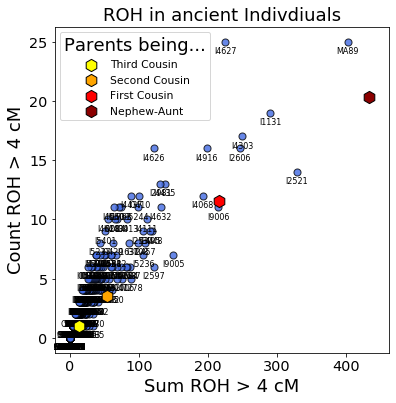

In [56]:
plot_sard_inbreed(df_load, savepath="./figures_test/all_ancs.pdf",  
                  reference_pts=True, title= "ROH in ancient Indivdiuals", annotate=True)

In [57]:
df_load.head(10)

,iid,max_roh,sum_roh,n_roh
0,MA89,40.350711,402.742118,25
1,I2521,68.356599,328.405093,14
2,I1131,39.564692,290.128077,19
3,I4303,38.987696,249.915520,17
4,I2606,35.242498,246.370990,16
5,I4627,27.123297,225.124087,25
6,I9006,62.245902,215.232998,11
7,I4916,45.426095,198.441118,16
8,I4068,54.713997,192.621688,12
9,I9005,57.713205,149.654708,7


# Do Modern Populations
Based on first run of HO from August 2019

In [7]:
%%time
pop_list = ["Czech", "Bergamo", "Basque", 'Spanish', 'French', 'Croatian', "Cag", "Ogl", "Olb", "Car", "Cam", "Ori", "Sas", "Nuo"]
#pop_list = ["Ogl"]

iids = get_modern_iids("./Data/Marcus2019_1240k/meta_rev_unique_ids.csv", pop_list, mod_ind=1098, max_n=20)

Loaded 250 Individuals
CPU times: user 33.9 ms, sys: 0 ns, total: 33.9 ms
Wall time: 32.1 ms


In [43]:
%%time
df1 = create_ancsard_df(iids, min_cm = 4, snp_cm=50, prefix_out="e01/", path_folder= "./Empirical/1240k/HO/", 
                        output = False, savepath = "")   # Load, process and save as .csv ./Empirical/1240k/modern_roh_summary.csv

CPU times: user 2.25 s, sys: 119 ms, total: 2.36 s
Wall time: 4.57 s


### Repeat for All Modern Populations

In [63]:
#pop_list = ["Basque", 'Spanish', 'French', 'Croatian', "Cag", "Ogl", "Olb"]
#pop_list = ["Car", "Cam", "Ori", "Sas", "Nuo", "Czech", "Bergamo"]
#pop_list = ["Italian_South", "Sicilian", "Icelandic", "Norwegian", "English", "Greek"]
pop_list = ["Basque", "Bergamo", 'Spanish', 'French', 'Croatian', 'Albanian',  'Ashkenazi_Jew', 'Belarusian', 'Bulgarian', 'Estonian', 'Finnish', 'French_South', 'Hungarian', 
            'Lithuanian', 'Maltese', 'Russian', 'Scottish', 'Spanish_North', 'Turkish', 'Tuscan', 'Ukrainian',
           "Italian_South", "Sicilian", "Icelandic", "Norwegian", "English", "Greek"]

iids = get_modern_iids("./Data/Marcus2019_1240k/meta_rev_unique_ids.csv", pop_list, mod_ind=1098, max_n=20)

Loaded 308 Individuals


In [64]:
%%time
df1 = create_ancsard_df(iids, min_cm = 4, snp_cm=50, prefix_out="e01/", path_folder= "./Empirical/1240k/HO/", 
                        output = False, savepath = "./Empirical/1240k/HO_roh_summary.csv")  # Load, process and save as .csv ./Empirical/1240k/modern_roh_summary.csv

Saved to: ./Empirical/1240k/HO_roh_summary.csv
CPU times: user 37.7 s, sys: 2.02 s, total: 39.8 s
Wall time: 1min 33s


# Load saved Data
Speeds up as no recalling needs to be done

In [4]:
#path_rohs_info = "./Empirical/1240k/modern_roh_summary.csv"      # Present-day ROH Data
path_rohs_info = "./Empirical/1240k/ancsards_roh_summary.csv"     # Ancient ROH Data
df_load = pd.read_csv(path_rohs_info)

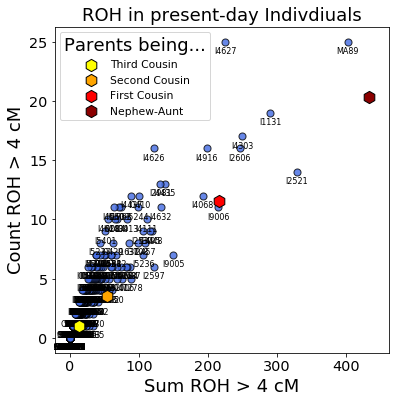

In [6]:
savepath="./figures_test/modern_ogl_cumroh.pdf"
savepath = ""
# Enter df_load if necessary
plot_sard_inbreed(df_load, savepath=savepath, reference_pts=True, title= "ROH in present-day Indivdiuals", annotate=True)

In [ ]:
df1[df1["iid"].str.startswith("Sicilian")]

# Plot ROH against vrs Variables
Stand Alone, loads the summary .csv saved above

In [10]:
path_rohs_info = "./Empirical/1240k/ancsards_roh_summary.csv"
df1 = pd.read_csv(path_rohs_info)
print(f"Loaded {len(df1)} Individuals")

full_df = pd.merge(df1, meta_df[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")

Loaded 557 Individuals


In [4]:
def plot_age_roh(full_df, pop_groups=[], pop_labels=[], pop_colors = [],
                 savepath = "./Empirical/AncSards/roh_summary_age.pdf", ylim=[], xlim=[], fsl=18, s=50):
    """Plot ROH against Age.
    pop_groups: List of List of populations to plot
    pop_labels: List of Labels for the Populations
    pop_colors: List of Colors for the Populations to plot"""
    assert(len(pop_groups)==len(pop_labels)==len(pop_colors))
    
    x, y = full_df["age"] - 1950, full_df["sum_roh"]
    
    _, _, r2, p_value, _ = stats.linregress(x, y)
    print(p_value)
 
    ### Hack in the colors:
    colors = np.array(["royalblue" for _ in range(len(full_df))])

    plt.figure(figsize=(10,6))
    ax = plt.gca()
    
    plt.scatter(x, y, s=s, edgecolors="k", c="gray")  # Plot the Background
    
    for i, pops in enumerate(pop_groups):
        inds = full_df["clst"].isin(pops)

        plt.scatter(x[inds], y[inds], c=pop_colors[i], s=s, 
                    edgecolors="k", label = pop_labels[i])
        
    plt.xlabel("Age BCE [years]", fontsize=fsl)
    plt.ylabel("Sum ROH >4 cM [cM]", fontsize=fsl)
    ax.invert_xaxis()
    
    plt.text(0.8, 0.8, f"r: {r2:.3f}", ha='left', va='center', transform = ax.transAxes, fontsize=14)
    plt.text(0.8, 0.75, f"p: {p_value:.6f}", ha='left', va='center', transform = ax.transAxes, fontsize=14)
    
    plt.legend(loc="upper left", fontsize=fsl)
    
    if len(ylim)>0:
        plt.ylim(ylim)
        
    if len(xlim)>0:
        plt.xlim(xlim)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()
    
    
def plot_cov_roh(full_df, savepath = "./Empirical/AncSards/roh_summary_cov.pdf", ylim=[], xlim=[], fsl=18, s=40):
    """Plot ROH against Age"""
    x, y = full_df["mean_cov"], full_df["sum_roh"]
    age = full_df["age"]
    
    _, _, r2, p_value, _ = stats.linregress(x, y)

    
    ### Do Linear Regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(full_df["mean_cov"], full_df["sum_roh"])
    slope, intercept, r_value, p_value, std_err

    plt.figure(figsize=(12,6))
    ax = plt.gca()
    plt.scatter(x, y, c=age, s=s, edgecolors="k", cmap="viridis_r") # royalblue
    plt.xlabel("Avg. 1240k Depth", fontsize=fsl)
    plt.ylabel("Sum ROH >4 cM", fontsize=fsl)
    #ax.invert_xaxis()
    
    plt.text(0.8, 0.8, f"r: {r2:.3f}", ha='left', va='center', transform = ax.transAxes, fontsize=14)
    plt.text(0.8, 0.75, f"p: {p_value:.4f}", ha='left', va='center', transform = ax.transAxes, fontsize=14)
    
    cb = plt.colorbar()
    #cb.ax.set_yticklabels(['0','1','2','>3'])
    cb.set_label('Age [y BP]', rotation=270, fontsize=fsl, labelpad=20)

    if len(ylim)>0:
        plt.ylim(ylim)
        
    if len(xlim)>0:
        plt.xlim(xlim)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
        
    plt.show()

3.612293385008778e-05


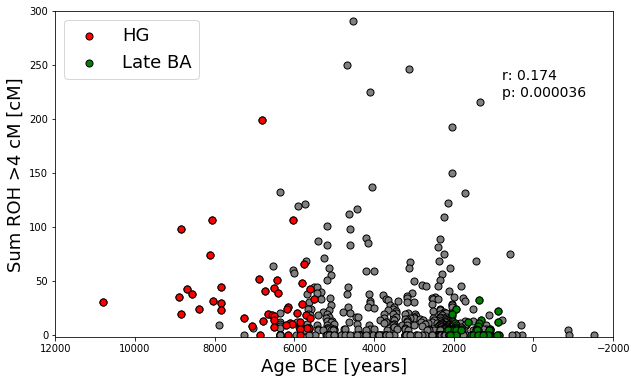

In [98]:
hg_pops = ["WHG-HG", 'EHG-HG', 'Ukraine-HG', 'SHG-HG', 'Iron_Gates-HG', "Natufian-HG"]
ba_pops = ["CE-LBA", "GB-LBA"]

pop_groups=[hg_pops, ba_pops]
pop_labels=["HG", "Late BA"] 
pop_colors = ["red", "green"]

plot_age_roh(full_df, pop_groups=pop_groups, pop_labels=pop_labels, pop_colors=pop_colors, 
             savepath="", ylim=[-2,300], xlim=[12000, -2000])

### Zoom in a bit:

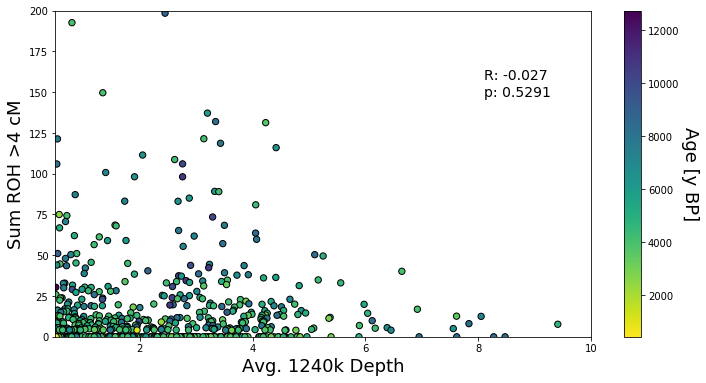

In [61]:
plot_cov_roh(full_df, savepath="", ylim=[0,200], xlim=[0.5, 10], s=40)

# Load and plot HO Data
September 2019. Post-process the Summary Statistics from each Individual
into one dataframe compatible with the above functions
The Folder of the csvs used in this analysis ./Empirical/HO/

Apart from Plotting Function, stand-alone from here on

In [3]:
meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
meta_df = pd.read_csv(meta_path)

In [4]:
def give_iid_paths_ho(meta_df, ind_range, base_folder="./Empirical/HO/"):
    """Produce a list of paths for .csvs
    ind_range: List of Integer Indices in HO subset"""
    ho_df = meta_df[meta_df["study"]=="Lazaridis et al. 2014"]
    iids = ho_df["iid"].values[ind_range]  # Extract Individuals
    pops = ho_df["clst"].values[ind_range]
    
    ### Produce the Paths
    paths_csv = [os.path.join(base_folder, str(iid) + "_roh_full.csv") for iid in iids]
    return paths_csv, iids, pops  

def create_ho_ROH_df(paths, iids, pops, min_cm=4, snp_cm=100, 
                     savepath = "./Empirical/HO/roh_summary_HO.csv", gap=0.5, output=True):
    """Create the Ancient Sardinian Summary Dataframe
    paths: List of .csv Paths to load the Data from
    snp_cm: Minimum SNP Density per cM
    savepath: If given, where to save the summary .csv to
    gap: Gaps to merge [in cM]"""
    n = len(paths)

    # Default Values: Zero ROH
    max_roh = np.zeros(n, dtype="float")
    sum_roh = np.zeros(n, dtype="float")
    n_roh = np.zeros(n, dtype="int")

    for i, path in enumerate(paths):
        df_roh = pd.read_csv(path)
        if gap>0:
            df_roh = merge_called_blocks(df_roh, max_gap=gap/100)
        df_roh = post_process_roh_df(df_roh, output=output, snp_cm=snp_cm, min_cm=min_cm)  ### Do the Postprocessing
        max_roh[i], sum_roh[i], n_roh[i] = individual_roh_statistic(df_roh, output=output)

    ### Create the Dataframe:
    d = {"iid": iids, "pop" : pops, "max_roh": max_roh*100, "sum_roh" : sum_roh*100, "n_roh" : n_roh}
    df1 = pd.DataFrame(d).sort_values(by="sum_roh", ascending=False)  # Sort output
    
    if len(savepath) > 0:
        df1.to_csv(savepath, sep=",", index=False)
        print(f"Saved to: {savepath}")
        
    return df1

def save_full_ho_roh_df(df, meta_df, save_path):
    """Save the full Human Origin Result df 
    (and merge in GPS),
    merging in relevant data from meta_df"""
    
    ### Merge in GPS Data    
    save_df = pd.merge(df, meta_df[["iid", "lat", "lon", "age"]], on="iid")
    print(f"GPS found {len(save_df)} / {len(df)}")
    save_df.to_csv(save_path, sep="\t", index=False)
    print(f"Successfully saved to {save_path}")
    return save_df

### Create the Dataframe with all ROH sharing

In [5]:
%%time
paths, iids, pops = give_iid_paths_ho(meta_df, range(0,1941), base_folder="./Empirical/HO/")
df1 = create_ho_ROH_df(paths, iids, pops, min_cm=4, snp_cm=50, savepath="", gap=1.0, output=False)

CPU times: user 2min 39s, sys: 246 ms, total: 2min 39s
Wall time: 2min 51s


In [6]:
save_df = save_full_ho_roh_df(df1, meta_df, save_path="./Empirical/HO/CombinedROH/combinedroh.csv") # Save if needed

GPS found 1941 / 1941
Successfully saved to ./Empirical/HO/CombinedROH/combinedroh.csv


In [9]:
### Load Again
df1 = pd.read_csv("./Empirical/HO/CombinedROH/combinedroh.csv", '\t')

In [10]:
df1.head(10)

,iid,pop,max_roh,sum_roh,n_roh,lat,lon,age
0,Surui_0,Surui,45.051694,699.549421,48,-11.0,-62.0,0.0
1,Karitiana_11,Karitiana,71.722305,617.914425,37,-10.0,-63.0,0.0
2,Surui_1,Surui,92.519199,602.821457,30,-11.0,-62.0,0.0
3,Makrani_12,Makrani,39.371300,568.998682,34,26.0,64.0,0.0
4,Lebanese_6,Lebanese,59.008193,558.271169,29,33.8,35.6,0.0
5,Pima_11,Pima,124.891199,545.830279,30,29.0,-108.0,0.0
6,Surui_4,Surui,50.708199,520.633400,33,-11.0,-62.0,0.0
7,Surui_7,Surui,36.485505,508.582498,38,-11.0,-62.0,0.0
8,Surui_6,Surui,96.734203,482.479889,28,-11.0,-62.0,0.0
9,Kusunda_8,Kusunda,17.500895,466.058208,63,28.1,82.5,0.0


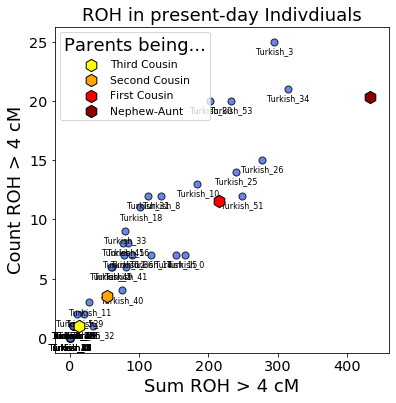

In [12]:
df_plot = df1[df1["pop"]=="Turkish"]
#df_plot = df1
plot_sard_inbreed(df_plot, savepath="", reference_pts=True, title= "ROH in present-day Indivdiuals", annotate=True, min_cm=4)

In [52]:
len(df1[df1["pop"]=="Turkey"])

0

In [68]:
df1.head(30)

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
0,Loschbour_published.DG,39.489495,2576.777525,223,49.810000,6.400000,8050.0,LazaridisNature2014,Luxembourg_Loschbour_published.DG,22.000000,1139327,1
1,Loschbour_snpAD.DG,70.030102,2514.974574,208,49.810000,6.400000,8050.0,Pruefer2017,Luxembourg_Loschbour.DG,22.000000,1062011,1
2,Stuttgart_published.DG,66.225002,2126.031034,214,48.780000,9.180000,7140.0,LazaridisNature2014,Germany_LBK_EN_Stuttgart_published.DG,19.000000,1130723,1
3,UstIshim_snpAD.DG,77.689099,2100.111203,204,57.700000,71.100000,45020.0,Pruefer2017,Ust_Ishim.DG,42.000000,1062044,1
4,Ust_Ishim_published.DG,34.012592,2014.478393,213,57.700000,71.100000,45020.0,FuNature2014,Ust_Ishim_HG_published.DG,42.000000,1147829,1
5,Vindija_snpAD.DG,47.738701,1750.438853,156,NaN,NaN,41950.0,Pruefer2017,Vindija.DG,30.000000,1061414,1
6,Altai_published.DG,47.641802,1563.865504,158,51.397500,84.676111,51950.0,PrueferNature2013,Altai_published.DG,52.000000,1149663,1
7,Altai_snpAD.DG,47.641802,1549.540638,148,51.397500,84.676111,51950.0,Pruefer2017,Altai.DG,52.000000,1061534,1
8,Goyet_final.SG,33.057809,1403.052404,149,50.446000,5.008000,42540.0,HajdinjakNature2018,Goyet_Neanderthal.SG,0.851000,655315,1
9,Les_Cottes_final.SG,28.030503,1038.976193,121,NaN,NaN,43230.0,HajdinjakNature2018,Les_Cottes_Neanderthal.SG,0.587000,479923,1


# Plot / Analyze ROH in the Reich Eigenstrat File

In [33]:
df1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh.csv", '\t')
print(f"Loaded {len(df1)} Individuals")

Loaded 1098 Individuals


In [34]:
df_cony = df1[df1["study"] == "delaFuentePNAS2018"]
#df_cony = df1[df1["study"] == "RaghavanScience2015"]
df_cony

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
12,IPK13a.SG,31.267608,539.690993,67,-49.139722,-74.451944,1193.0,delaFuentePNAS2018,Chile_Kaweskar_1000BP.SG,3.5,1044915,1
14,IPK12.SG,30.227202,501.053778,58,-52.350000,-70.966667,863.0,delaFuentePNAS2018,Chile_Kaweskar_1000BP.SG,7.8,1142798,1
41,IPY08b.SG,12.946699,309.061452,54,-55.250000,-69.016667,1000.0,delaFuentePNAS2018,Chile_Yamana_1000BP.SG,1.7,903809,1


In [75]:
df1[df1["age"]<12000][:100]

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
5,SN-44.SG,66.042196,883.040129,80,33.264278,-119.539000,5337.0,ScheibScience2018,E_San_Nicolas.SG,3.097140,1111229,1
8,I1178,91.287404,730.644607,33,32.974167,35.331389,5950.0,HarneyMayNatureCommunications2018,Israel_C,2.383000,719331,1
11,SN-13.SG,62.535000,552.840777,46,33.264278,-119.539000,811.0,ScheibScience2018,L_San_Nicolas.SG,0.580568,509837,1
12,IPK13a.SG,31.267608,539.690993,67,-49.139722,-74.451944,1193.0,delaFuentePNAS2018,Chile_Kaweskar_1000BP.SG,3.500000,1044915,1
13,I0308,46.770900,524.187288,57,-38.360556,-60.244167,7435.0,PosthNakatsukaCell2018,Argentina_ArroyoSeco2_7700BP,0.530000,454002,1
14,IPK12.SG,30.227202,501.053778,58,-52.350000,-70.966667,863.0,delaFuentePNAS2018,Chile_Kaweskar_1000BP.SG,7.800000,1142798,1
15,I1357,40.709394,488.874228,55,-14.275556,-74.843611,925.0,PosthNakatsukaCell2018,Peru_Laramate_900BP,1.220000,721235,1
17,A460.SG,30.377900,456.060958,59,-50.100000,-75.240000,5121.0,MorenoMayarScience2018,Chile_Ayayema_5100BP.SG,10.318539,1181323,1
18,I0041,17.835498,446.876964,69,-10.322200,-76.666667,8505.0,PosthNakatsukaCell2018,Peru_Lauricocha_8600BP,0.794000,576466,1
19,I11974,16.637600,438.750165,66,-31.920000,-71.500000,11990.0,PosthNakatsukaCell2018,Chile_LosRieles_12000BP,2.985034,828852,1


In [80]:
df1[df1["iid"]=="UstIshim_snpAD.DG"]

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
134,UstIshim_snpAD.DG,18.286395,130.546949,19,57.7,71.1,45020.0,Pruefer2017,Ust_Ishim.DG,42.0,1062044,1


In [65]:
df1[df1["lon"]<-30]

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
10,SN-44.SG,66.042196,883.040129,80,33.264278,-119.539000,5337.0,ScheibScience2018,E_San_Nicolas.SG,3.097140,1111229,1
16,SN-13.SG,62.535000,552.840777,46,33.264278,-119.539000,811.0,ScheibScience2018,L_San_Nicolas.SG,0.580568,509837,1
17,IPK13a.SG,31.267608,539.690993,67,-49.139722,-74.451944,1193.0,delaFuentePNAS2018,Chile_Kaweskar_1000BP.SG,3.500000,1044915,1
18,I0308,46.770900,524.187288,57,-38.360556,-60.244167,7435.0,PosthNakatsukaCell2018,Argentina_ArroyoSeco2_7700BP,0.530000,454002,1
19,IPK12.SG,30.227202,501.053778,58,-52.350000,-70.966667,863.0,delaFuentePNAS2018,Chile_Kaweskar_1000BP.SG,7.800000,1142798,1
20,I1357,40.709394,488.874228,55,-14.275556,-74.843611,925.0,PosthNakatsukaCell2018,Peru_Laramate_900BP,1.220000,721235,1
22,A460.SG,30.377900,456.060958,59,-50.100000,-75.240000,5121.0,MorenoMayarScience2018,Chile_Ayayema_5100BP.SG,10.318539,1181323,1
23,I0041,17.835498,446.876964,69,-10.322200,-76.666667,8505.0,PosthNakatsukaCell2018,Peru_Lauricocha_8600BP,0.794000,576466,1
24,I11974,16.637600,438.750165,66,-31.920000,-71.500000,11990.0,PosthNakatsukaCell2018,Chile_LosRieles_12000BP,2.985034,828852,1
27,I8350,33.511199,396.233566,60,-36.077222,-62.347222,7700.0,PosthNakatsukaCell2018,Argentina_LagunaChica_6800BP,0.545923,388848,1


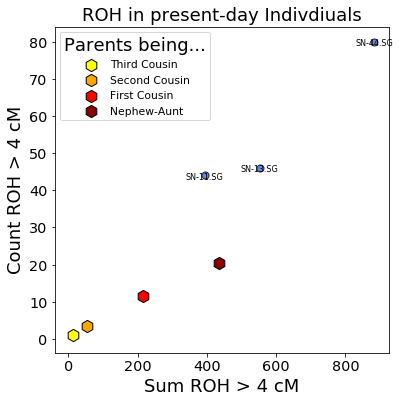

In [78]:
#df_plot = df1[df1["study"]=="HarneyMayNatureCommunications2018"]
df_plot = df1[df1["lon"]<-30]
df_plot = df_plot[df_plot["clst"].str.endswith("San_Nicolas.SG")]
plot_sard_inbreed(df_plot, savepath="", reference_pts=True, title= "ROH in present-day Indivdiuals", annotate=True, min_cm=4)

In [ ]:
full_df

# Compare ROH from Eigenstrat and from Marcus RC Data

In [132]:
df_rc = pd.read_csv("./Empirical/1240k/ancsards_roh_summary.csv")
df_es = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh.csv", '\t')  # Load ES Data

In [133]:
df_merge = pd.merge(df_rc, df_es, on="iid")
print(f"Merged to {len(df_merge)} Inds. (from {len(df_rc)} and {len(df_es)}) resp.")

Merged to 497 Inds. (from 557 and 1098) resp.


In [134]:
df_merge = df_merge[df_merge["n_cov_snp"] > 500000]
df_merge = df_merge[df_merge["age"] < 7000]
df_merge = df_merge[df_merge["include_alt"] > 0]
print(f"Filtered to {len(df_merge)} high coverage Individuals")
df_merge.head(2)

Filtered to 310 high coverage Individuals


,iid,max_roh_x,sum_roh_x,n_roh_x,max_roh_y,sum_roh_y,n_roh_y,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
1,I1131,39.564692,290.128077,19,39.993691,315.085483,22,44.900,19.750,6483.0,MathiesonNature2018,Serbia_EN,2.922,776289,1
2,I4303,38.987696,249.915520,17,39.337897,275.172398,21,43.457,5.863,6633.0,OlaldeNature2018,France_MN,3.350,751782,1


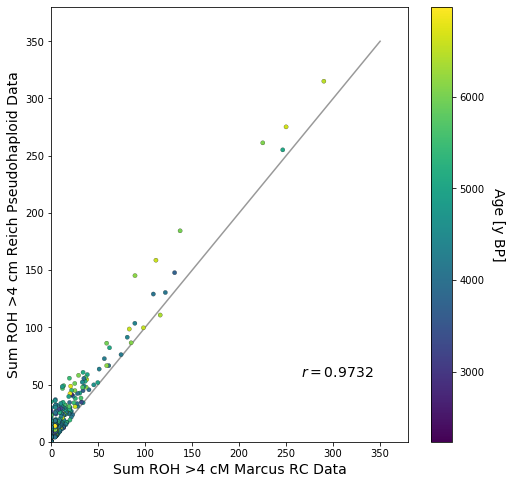

In [135]:
r = np.corrcoef(df_merge["sum_roh_x"], df_merge["sum_roh_y"])[0,1]
fs=14

plt.figure(figsize=(8,8))
ax=plt.gca()
plt.scatter(df_merge["sum_roh_x"], df_merge["sum_roh_y"], c=df_merge["age"],
            s=18, ec="k", lw=0.2, zorder=1)
plt.plot([0,350],[0,350], "gray", alpha=0.8, zorder=0)
plt.xlabel("Sum ROH >4 cM Marcus RC Data", fontsize=fs)
plt.ylabel("Sum ROH >4 cm Reich Pseudohaploid Data", fontsize=fs)
plt.xlim([0,380])
plt.ylim([0,380])
plt.text(0.7, 0.15, f"$r={r:.4f}$", transform=ax.transAxes, fontsize=fs)

cb = plt.colorbar()
cb.ax.set_ylabel("Age [y BP]", rotation=270, fontsize=fs, labelpad=20)

plt.show()

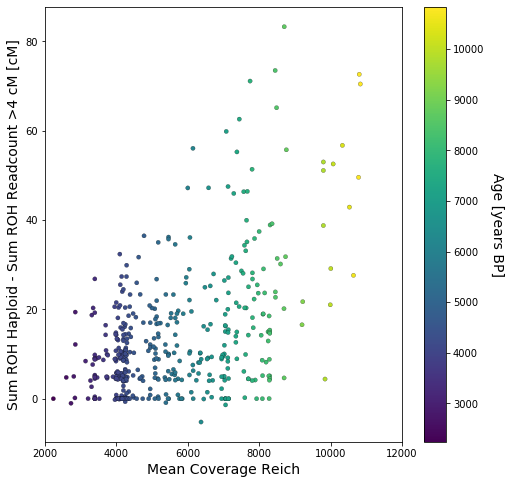

In [73]:
fs=14

plt.figure(figsize=(8,8))
ax=plt.gca()
plt.scatter(df_merge["age"], df_merge["sum_roh_y"] - df_merge["sum_roh_x"], c=df_merge["age"],
            s=18, ec="k", lw=0.2, zorder=1)
plt.plot([0,14],[1,1], "gray", alpha=0.8, zorder=0)
plt.ylabel("Sum ROH Haploid - Sum ROH Readcount >4 cM [cM]", fontsize=fs)
plt.xlabel("Mean Coverage Reich", fontsize=fs)
plt.xlim([2000,12000])
#plt.ylim([0,380])
#plt.text(0.7, 0.15, f"$r={r:.4f}$", transform=ax.transAxes, fontsize=fs)

cb = plt.colorbar()
cb.ax.set_ylabel("Age [years BP]", rotation=270, fontsize=fs, labelpad=20)

plt.show()

In [89]:
### Merge in info from original Meta as well
meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
meta_df = pd.read_csv(meta_path)

In [106]:
df_merge_a=pd.merge(df_merge, meta_df, on="iid")
df_merge_a.head(2)
df_merge_a = df_merge_a[df_merge_a["sum_roh_x"]>0]
print(f"Reduced to {len(df_merge_a)} samples)")

Reduced to 299 samples)


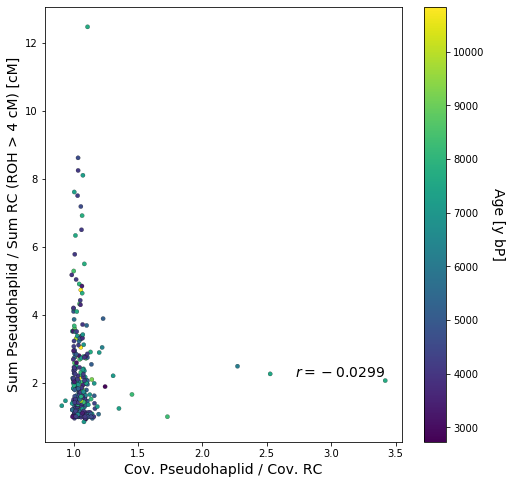

In [107]:
fs=14
r = np.corrcoef(df_merge_a["mean_cov_x"] / df_merge_a["mean_cov_y"], df_merge_a["sum_roh_y"] / df_merge_a["sum_roh_x"])[0,1]


plt.figure(figsize=(8,8))
ax=plt.gca()
plt.scatter(df_merge_a["mean_cov_x"] / df_merge_a["mean_cov_y"], df_merge_a["sum_roh_y"] / df_merge_a["sum_roh_x"], c=df_merge_a["age_x"],
            s=18, ec="k", lw=0.2, zorder=1)
#plt.plot([0,14],[1,1], "gray", alpha=0.8, zorder=0)
plt.ylabel("Sum Pseudohaplid / Sum RC (ROH > 4 cM) [cM]", fontsize=fs)
plt.xlabel("Cov. Pseudohaplid / Cov. RC", fontsize=fs)
#plt.xlim([0.0,1.0])
#plt.ylim([0,380])
plt.text(0.7, 0.15, f"$r={r:.4f}$", transform=ax.transAxes, fontsize=fs)

cb = plt.colorbar()
cb.ax.set_ylabel("Age [y bP]", rotation=270, fontsize=fs, labelpad=20)

plt.show()

In [49]:
df_merge_a[(df_merge_a["mean_cov_x"]>6) & (df_merge_a["mean_cov_y"] < 4)]

,iid,max_roh_x,sum_roh_x,n_roh_x,max_roh_y,sum_roh_y,n_roh_y,lat_x,lon_x,age_x,...,study_y,clst_alt,period_alt,include_alt_y,clst_y,mean_cov_y,med_cov,n_cov_snp_read,full_iid,n_cov_snp_y
260,I2794,4.8388,4.8388,1,6.0889,10.948801,2,47.191612,20.402331,7574.0,...,Lipson et al. 2017,Koros,EN,1,Balkans-MNCA,2.438818,2.0,808283.0,I2794,808283
341,I2366,0.0000,0.0000,0,5.6542,5.654200,1,47.620940,19.044940,5093.0,...,Lipson et al. 2017,Baden,LCA,1,Balkans-BA,1.974700,1.0,772215.0,I2366,772215
362,I2495,0.0000,0.0000,0,0.0000,0.000000,0,37.917740,30.708390,4377.0,...,Mathieson et al. 2018,Anatolia,BA,1,Anatolia-BA,1.912487,1.0,612103.0,I2495,612103


### Age structure of Americans

In [20]:
lat_okay = (df1["lat"]>-90) & (df1["lat"]<90)
lon_okay = (df1["lon"]>-150) & (df1["lon"]<-30)
df_sa = df1[lat_okay & lon_okay]
df_sa=df_sa[df_sa["include_alt"]>0]
df_sa["study"].value_counts()
#df_sa

PosthNakatsukaCell2018      29
MorenoMayarScience2018      12
ScheibScience2018            9
LindoScienceAdvances2018     5
RaghavanScience2015          3
delaFuentePNAS2018           3
RasmussenNature2014          2
RasmussenNature2010          1
Name: study, dtype: int64

No handles with labels found to put in legend.


0.31469089329942657


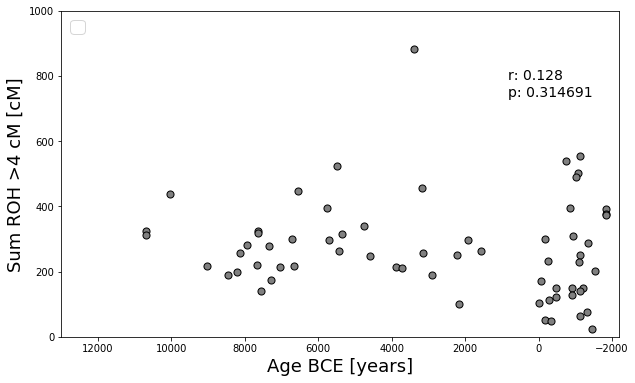

In [18]:
plot_age_roh(df_sa, pop_groups=[], pop_labels=[], pop_colors = [],
                 savepath = "", ylim=[0,1000], xlim=[13000,-2200], fsl=18, s=50)

# Area 51

In [21]:
ho_df = meta_df[meta_df["study"]=="Lazaridis et al. 2014"]
len(ho_df) # 

1941

In [74]:
give_iid_paths_ho(meta_df, ind_range=[130], base_folder="./Empirical/HO/")

(['./Empirical/HO/Balochi_3_roh_full.csv'],
 array(['Balochi_3'], dtype=object),
 array(['Balochi'], dtype=object))